In [43]:
%pip install torch torchvision fastai segmentation-models-pytorch opencv-python

In [44]:
from fastai.vision.all import *
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import csv

In [45]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [46]:
!nvidia-smi

Sat Jan 13 21:31:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              32W /  70W |  10413MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [47]:
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

Tesla T4
True


In [48]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off()
           for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i ==
                0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [49]:
# Function to save the metrics to a csv file
def save_metrics_to_csv(learner, file_path='deeplab_metrics.csv', **kwargs):
    recorder = learner.recorder
    metrics = np.stack(recorder.values)
    names = recorder.metric_names[1:-1]

    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Escribir las cabeceras (nombres de las métricas)
        writer.writerow(['epoch'] + names)

        # Escribir las métricas por época
        for epoch, metric_values in enumerate(metrics):
            writer.writerow([epoch + 1] + list(metric_values))

    print(f"Metrics saved to {file_path}")

In [50]:
path_to_dataset = Path('/content/drive/My Drive/FotosGranada/train')

In [51]:
def get_y_fn(x):
    return Path(str(x).replace('src', 'gt').replace('.jpg', '.png'))


def get_items(path):
    return get_image_files(path/'src')

In [52]:
# Definition of the function to normalize the mask
def normalize_mask(mask, mapping):
    if mask.ndim != 3 or mask.shape[-1] != 3:
        raise ValueError(
            "La máscara debe ser una imagen RGB con 3 canales de color.")
    h, w, _ = mask.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)
    for color, c in mapping.items():
        mask_class[(mask == color).all(axis=-1)] = c
    return mask_class

# Definition of the function to denormalize the mask
def denormalize_mask(mask_class, mapeo):
    inverse_map = {v: k for k, v in mapeo.items()}
    h, w = mask_class.shape
    mask_color = np.zeros((h, w, 3), dtype=np.uint8)
    for c in np.unique(mask_class):
        color = inverse_map[c]
        mask_color[mask_class == c] = color
    return mask_color


# Mapping between class and color
mapping_class_color = {
    (0, 0, 0): 0,     # Class 0
    (128, 64, 128): 1,  # Class 1 - Road
    (0, 0, 142): 2  # Class 2 - Car
}

# Function to get the mask from the image
def get_mask(item):
    msk_path = get_y_fn(item)
    msk = np.array(PILImage.create(msk_path))
    normalized_mask = normalize_mask(msk, mapping_class_color)

    return PILMask.create(normalized_mask.astype(np.int32))


In [53]:
def add_shadow(image, num_shadows, min_opacity, max_opacity):
    height, width = image.shape[:2]
    shadow_image = image.copy()

    for _ in range(num_shadows):
        # Randomly generate the shadow polygon
        x1, y1 = random.randint(0, width), random.randint(0, height)
        x2, y2 = random.randint(0, width), random.randint(0, height)
        x3, y3 = random.randint(0, width), random.randint(0, height)
        x4, y4 = random.randint(0, width), random.randint(0, height)

        # Create a black polygon to simulate the shadow
        poly = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
        cv2.fillPoly(shadow_image, [poly], (0, 0, 0))

        # Blending the shadow with the image
        alpha = random.uniform(min_opacity, max_opacity)
        mask = shadow_image.astype(bool)
        shadow_image = cv2.addWeighted(shadow_image, alpha, image, 1 - alpha, 0, image)
        image[mask] = shadow_image[mask]

    return image

class ShadowTransform(Transform):
    """
    Custom Transform for adding shadows.
    """
    def __init__(self, num_shadows=3, min_opacity=0.5, max_opacity=0.75):
        self.num_shadows = num_shadows
        self.min_opacity = min_opacity
        self.max_opacity = max_opacity

    def encodes(self, x: PILImage):
        return add_shadow(x, self.num_shadows, self.min_opacity, self.max_opacity)

In [54]:
validation_names = ['granada9.jpg', 'granada13.jpg', 'granada34.jpg', 'granada42.jpg', 'granada45.jpg', 'granada56.jpg', 'granada69.jpg', 'granada76.jpg', 'granada78.jpg', 'granada89.jpg']

# Function to split the dataset into train and validation
def splitter_func(items):
    valid_idx = [i for i, item in enumerate(items) if Path(item).name in validation_names]
    train_idx = [i for i, item in enumerate(items) if Path(item).name not in validation_names]
    return train_idx, valid_idx

In [55]:
# Values for the augmentation transforms
aug_transforms = aug_transforms(mult=2, do_flip=True, flip_vert=True,
                                max_rotate=90., min_zoom=0.8, max_zoom=3.0,
                                max_lighting=0.2, max_warp=0.2, p_affine=0.75,
                                p_lighting=0.75, xtra_tfms=None, size=None,
                                mode='bilinear', pad_mode='reflection',
                                align_corners=True, batch=False, min_scale=1)

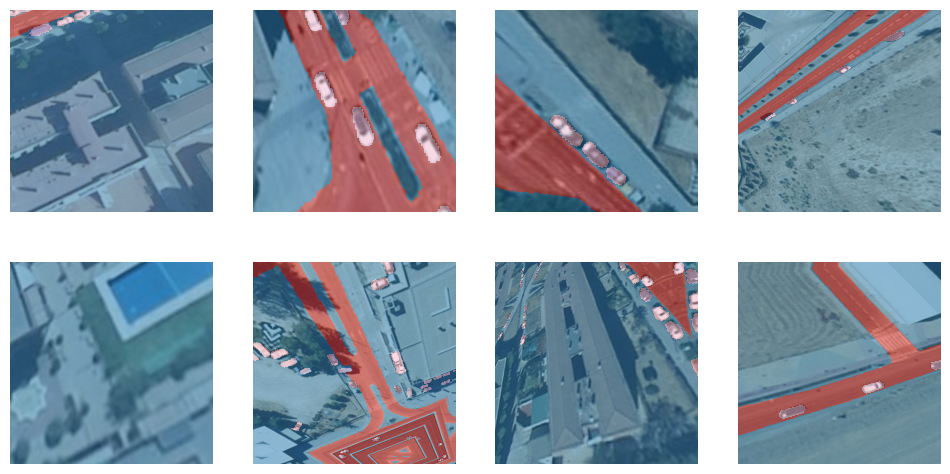

In [56]:
num_classes = 3

data = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=np.arange(num_classes))),
    get_items=get_items,
    get_y=get_mask,
    splitter=splitter_func,
    item_tfms=RandomResizedCrop(400, min_scale=0.75),
    batch_tfms=[*aug_transforms,Normalize.from_stats(*imagenet_stats)]
)

dls = data.dataloaders(path_to_dataset, bs=16)
dls.train.show_batch(max_n=8)

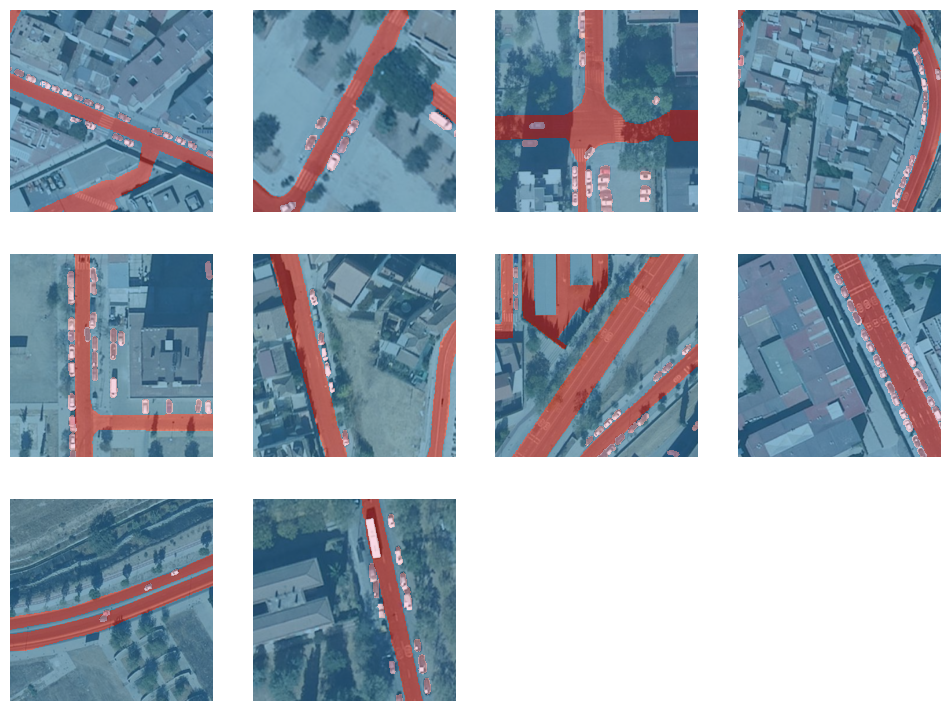

In [57]:
dls.valid.show_batch(max_n=10)

In [58]:
print(len(dls.valid.items))

10


## Model Import

In [59]:
learner = load_learner('/content/drive/My Drive/deeplab.pkl', cpu=True)
model = learner.model

In [60]:
learner = Learner(dls, model, loss_func=FocalLoss(), metrics=[foreground_acc, DiceMulti(), JaccardCoeffMulti()])

In [61]:
learner.summary()

/usr/local/lib/python3.10/dist-packages/fastai/metrics.py:373: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/usr/local/lib/python3.10/dist-packages/fastai/metrics.py:390: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


DeepLabV3Plus (Input shape: 16 x 3 x 400 x 400)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 200 x 200 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 100 x 100 
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     16 x 256 x 100 x 10 
Conv2d                                    16384      True      
BatchNorm2d                     

# Fine Tune (Prueba 1)

In [62]:
#learner.fine_tune(epochs=10,freeze_epochs=5)
learner.fit_one_cycle(20)

In [63]:
save_metrics_to_csv(learner, file_path='unet_metrics.csv')

Metrics saved to unet_metrics.csv


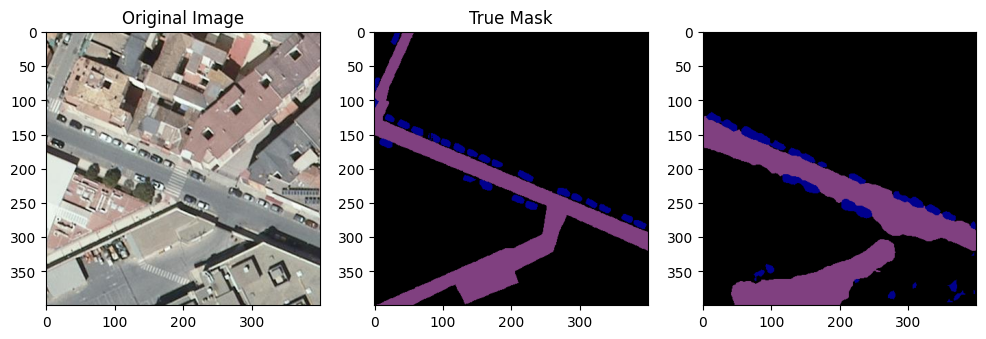

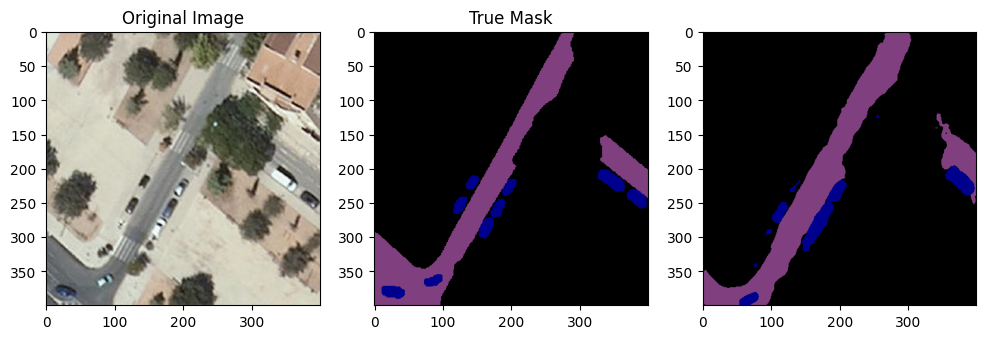

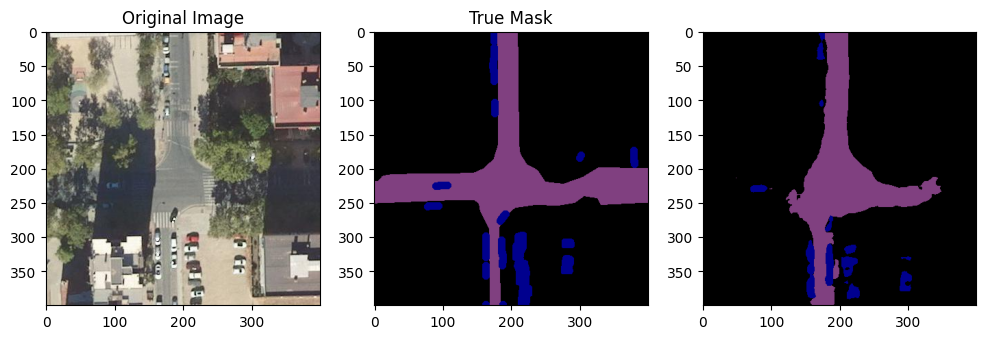

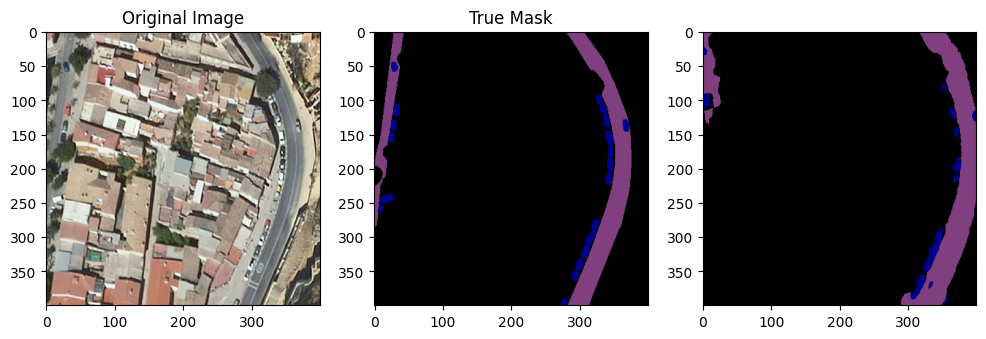

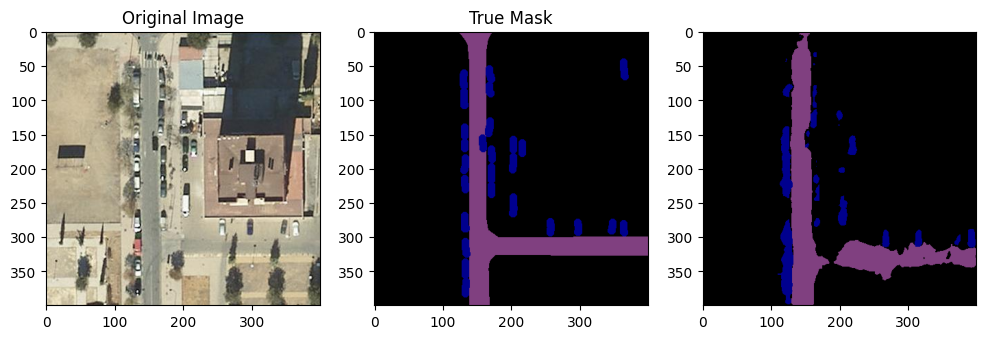

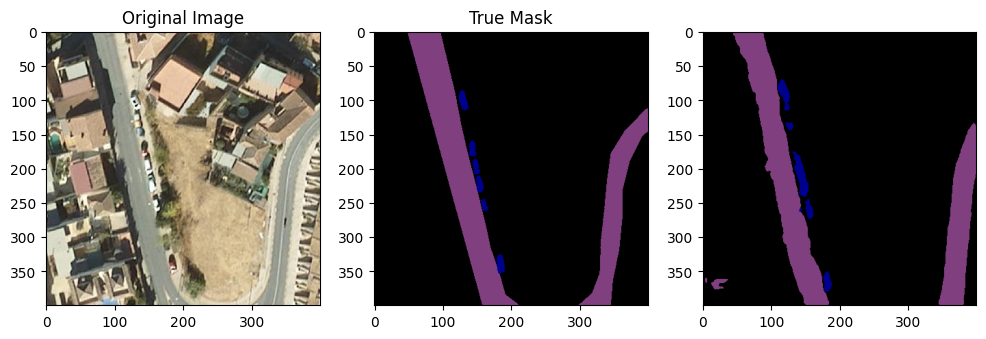

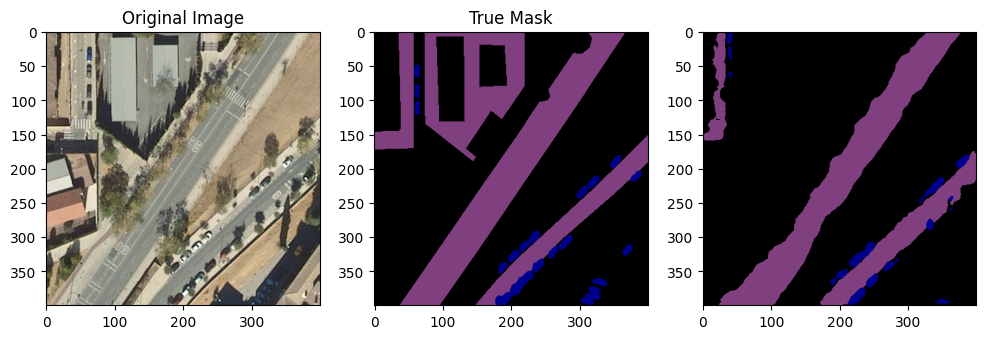

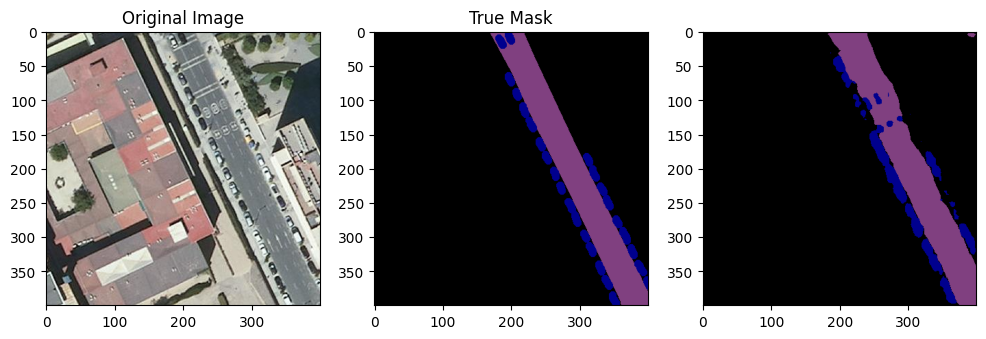

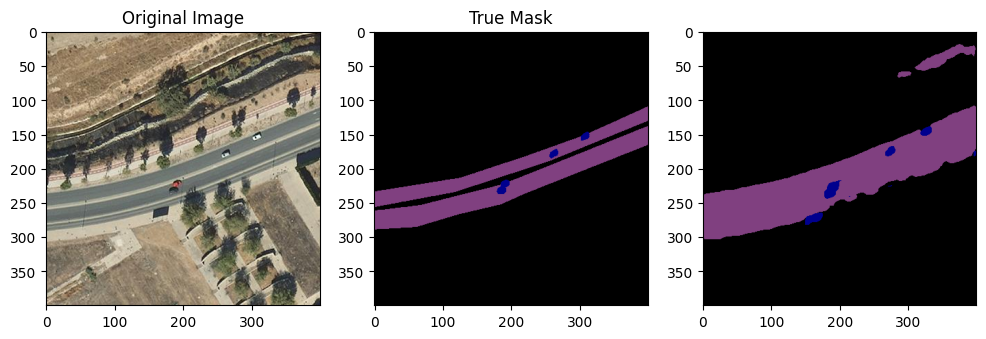

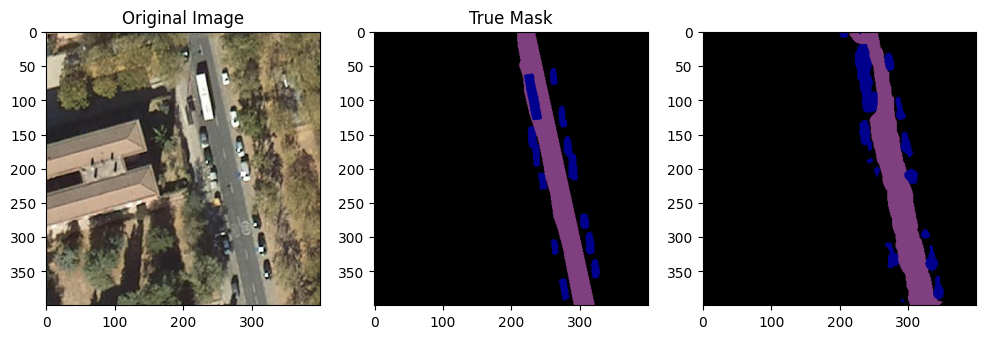

In [64]:
# Valid path
path_to_test = Path('/content/drive/My Drive/FotosGranada/val')

# Prepare the test dataset
test_items = learner.dls.valid.items
test_dl = learner.dls.test_dl(test_items)


# Get the predictions
preds, _ = learner.get_preds(dl=test_dl)

preds2 = []
targs2 = []

# Visualize the predictions
for i, (img, pred) in enumerate(zip(test_dl.items, preds)):
    original_image = PILImage.create(img).resize((400, 400))
    true_mask_path = get_y_fn(img)

    # Get the true mask
    true_mask = PILImage.create(true_mask_path).resize((400, 400), resample=Image.NEAREST)
    predicted_mask = denormalize_mask(pred.argmax(dim=0).numpy(), mapping_class_color)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    targs2.append(true_mask)
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    preds2.append(predicted_mask)

## Test Results

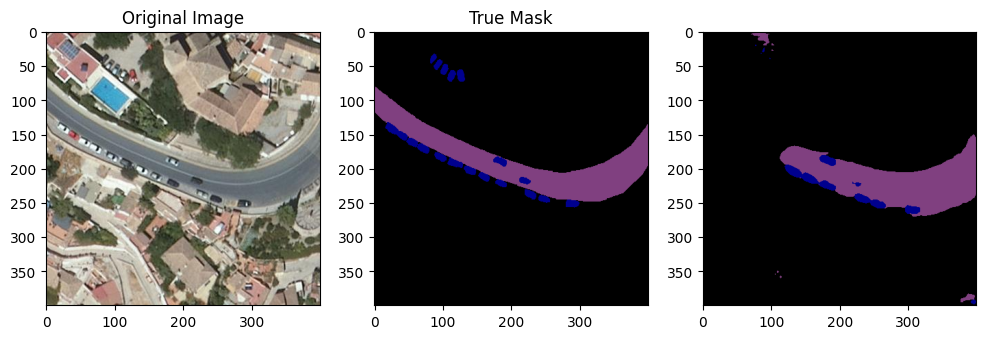

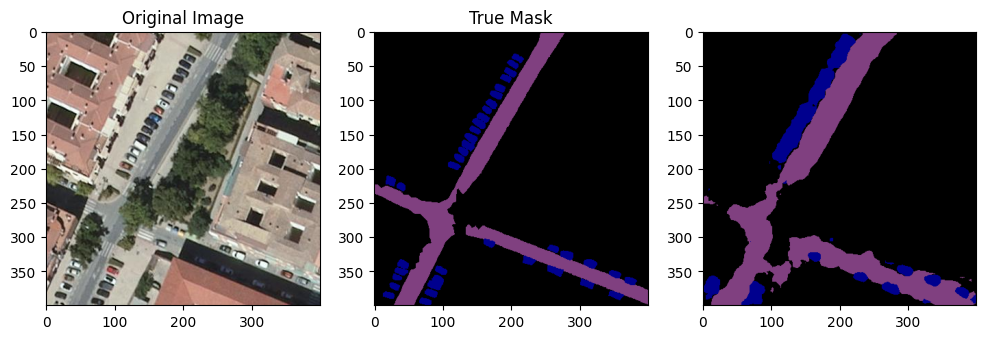

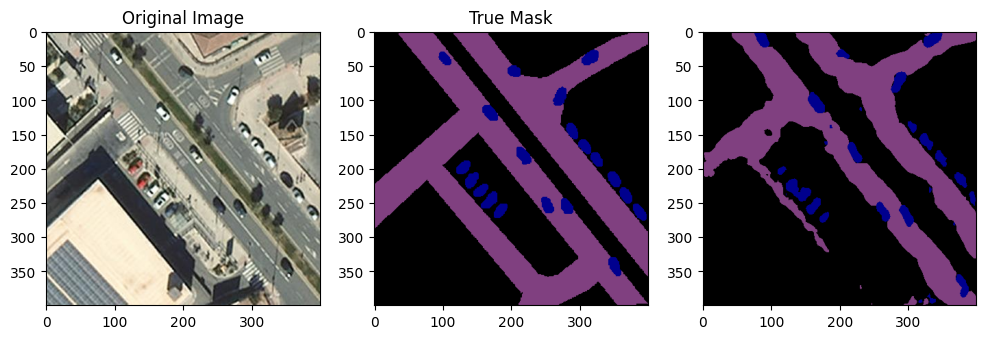

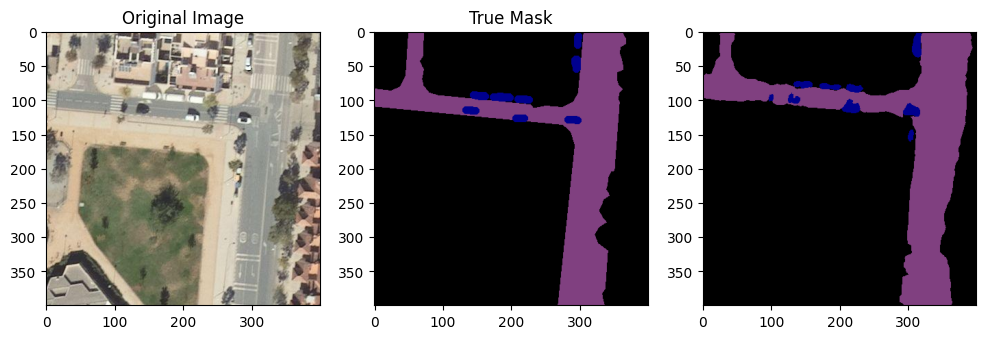

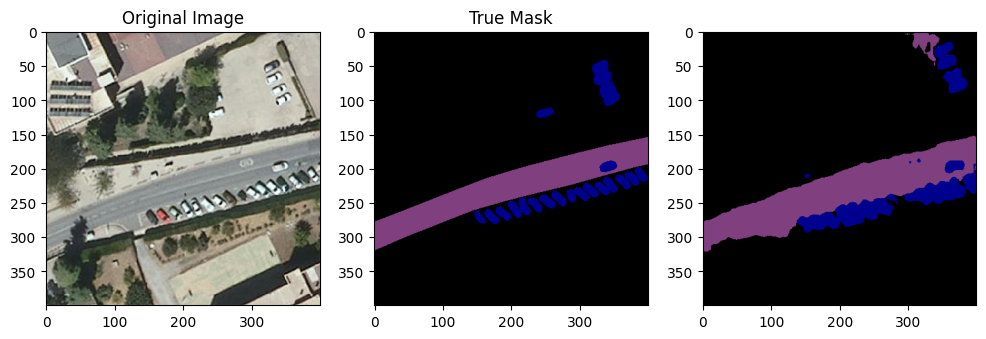

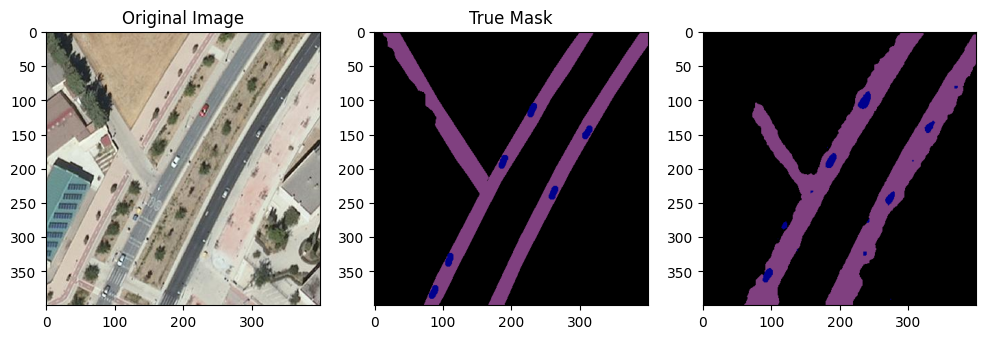

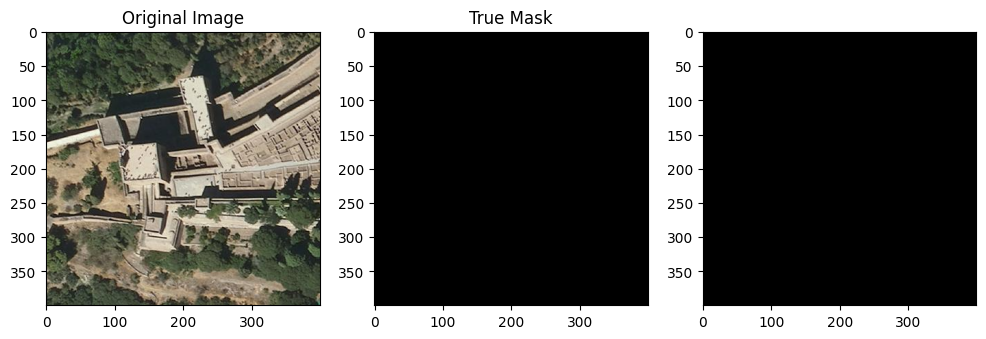

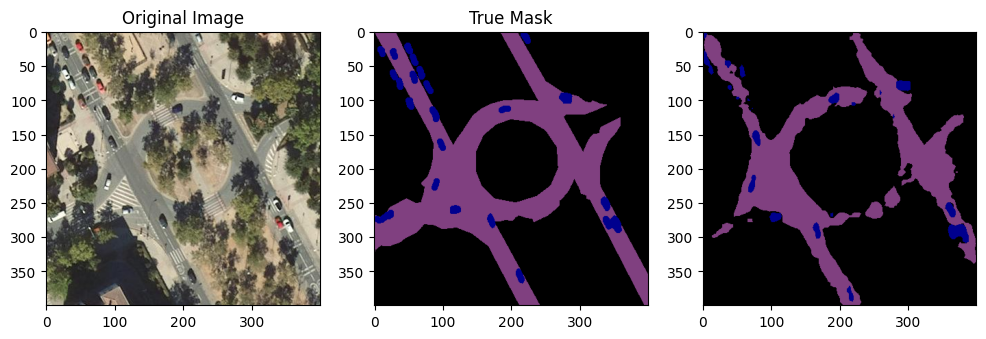

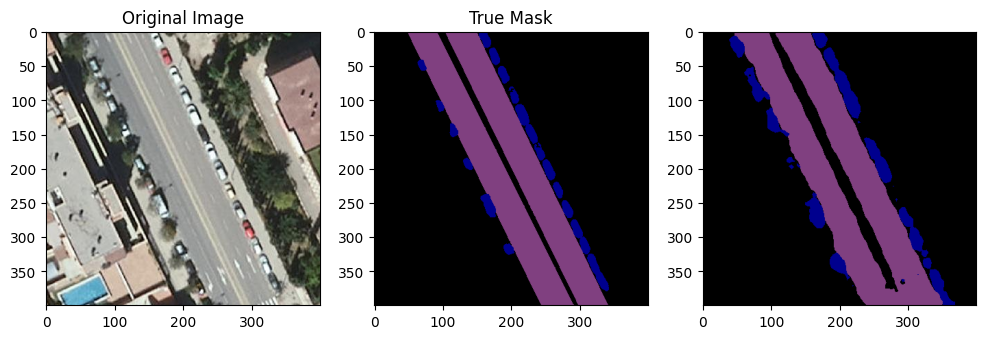

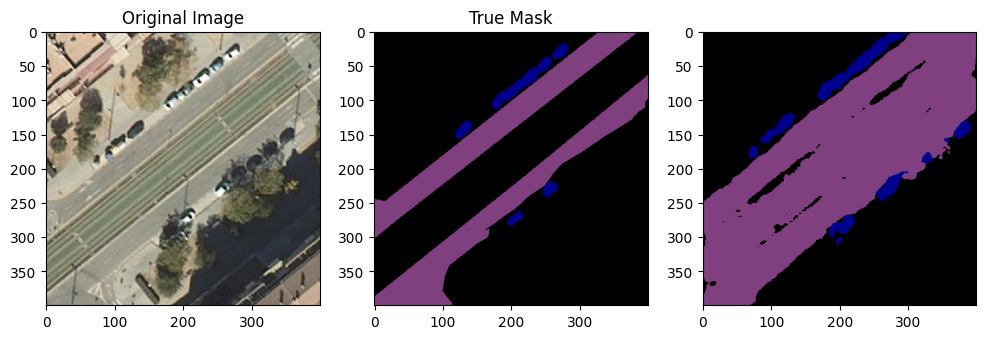

In [65]:
path_to_test = Path('/content/drive/My Drive/FotosGranada/val')

# Prepare the test dataset
test_items = get_items(path_to_test)
test_dl = learner.dls.test_dl(test_items)

# Make predictions
preds, _ = learner.get_preds(dl=test_dl)

# Path to the folder where the predicted images will be saved
output_folder = Path('/content/drive/My Drive/FotosGranada/predicted_images')
output_folder.mkdir(parents=True, exist_ok=True)

# Delete existing files in the output folder
for file in os.listdir(output_folder):
    file_path = output_folder / file
    try:
        if file_path.is_file():
            os.unlink(file_path)
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")


preds2 = []
targs2 = []

# Visualize the predictions
for i, (img, pred) in enumerate(zip(test_dl.items, preds)):
    original_image = PILImage.create(img).resize((400, 400))
    true_mask_path = get_y_fn(img)

    # Get the true mask
    true_mask = PILImage.create(true_mask_path).resize((400, 400), resample=Image.NEAREST)
    predicted_mask = denormalize_mask(pred.argmax(dim=0).numpy(), mapping_class_color)

    # Save the predicted image
    output_path = output_folder / f'predicted_image_{i}.png'
    predicted_image_pil = Image.fromarray(predicted_mask)
    predicted_image_pil.save(output_path)

    preds2.append(predicted_mask)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    targs2.append(true_mask)
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    preds2.append(predicted_mask)

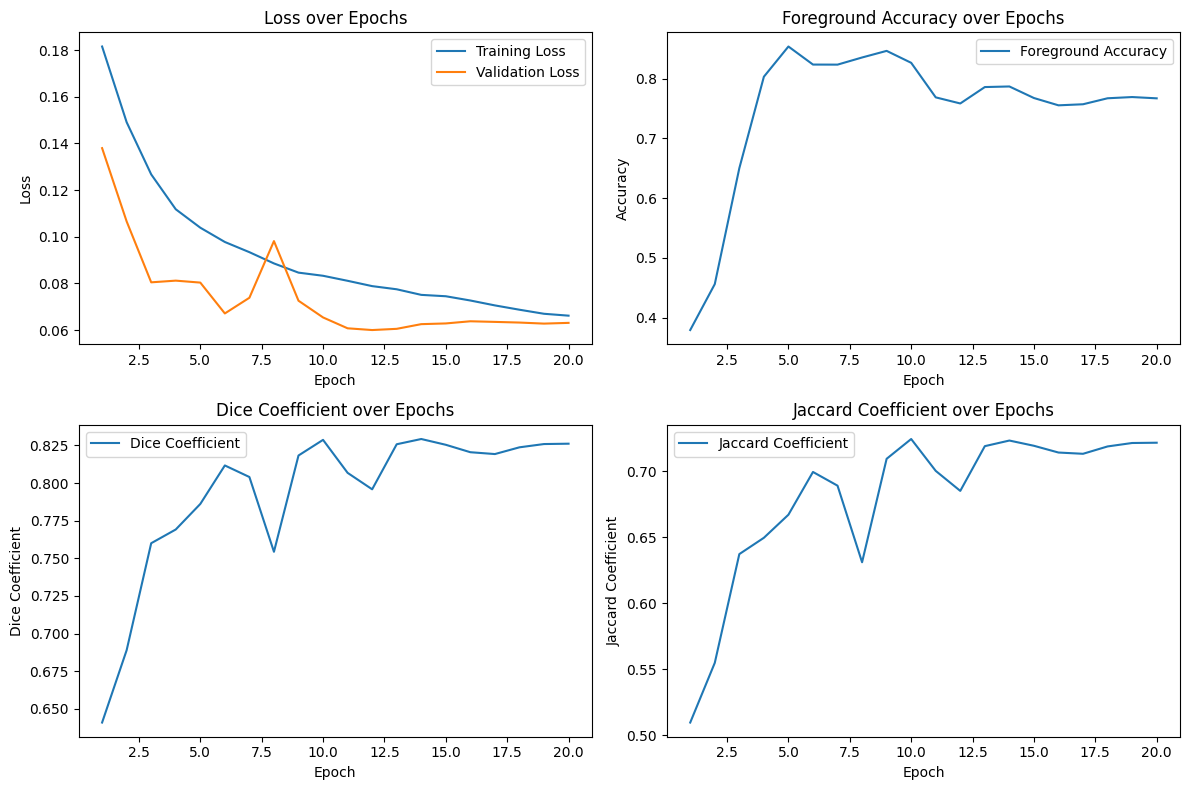

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the metrics from the csv file
df = pd.read_csv('unet_metrics.csv')

# Plot the metrics
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Training Loss')
plt.plot(df['epoch'], df['valid_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(df['epoch'], df['foreground_acc'], label='Foreground Accuracy')
plt.title('Foreground Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Dice Coefficient
plt.subplot(2, 2, 3)
plt.plot(df['epoch'], df['dice_multi'], label='Dice Coefficient')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# Jaccard Coefficient
plt.subplot(2, 2, 4)
plt.plot(df['epoch'], df['jaccard_coeff_multi'], label='Jaccard Coefficient')
plt.title('Jaccard Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Jaccard Coefficient')
plt.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## Final step: Spot parked cars

In [67]:
folder_path = '/content/drive/My Drive/FotosGranada/predicted_images'

blue_bgr = np.array([142, 0, 0])  # Car
black_bgr = np.array([0, 0, 0])   # Background
lilac_bgr = np.array([128, 64, 128])  # Road

# Iterates over all the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        # Create a mask for the blue pixels
        original_blue_mask = np.all(image == blue_bgr, axis=-1)

        # Find the contours of the blue pixels
        contours, _ = cv2.findContours(original_blue_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            mask = np.zeros_like(image[:,:,0], dtype=np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

            kernel = np.ones((15, 15), np.uint8)  # Create a 15x15 kernel
            dilated_mask = cv2.dilate(mask, kernel, iterations=1)  # Dilate the mask

            # Count the number of black and lilac pixels in the dilated mask
            black_count = np.sum(np.all(image[dilated_mask == 255] == black_bgr, axis=-1))
            lilac_count = np.sum(np.all(image[dilated_mask == 255] == lilac_bgr, axis=-1))

            # If there are more black pixels than lilac pixels, change the color of the pixels in the original image
            if black_count > lilac_count:
                change_mask = np.logical_and(original_blue_mask, mask)
                image[change_mask] = [0, 255, 255]

        # Save the image
        result_filename = f"{os.path.splitext(filename)[0]}_aparcado.png"
        result_path = os.path.join(folder_path, result_filename)
        cv2.imwrite(result_path, image)


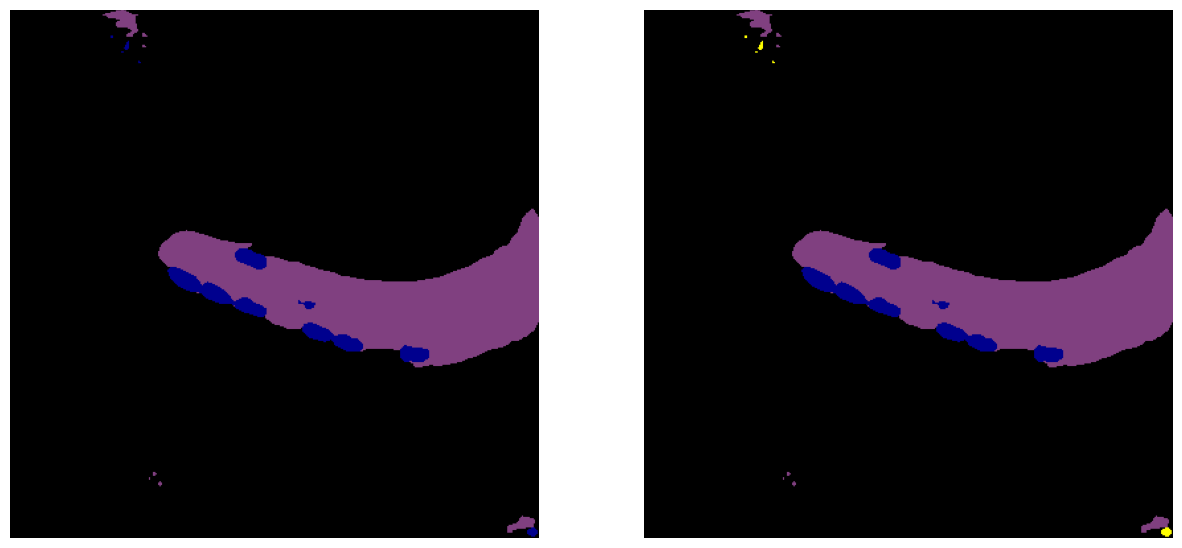

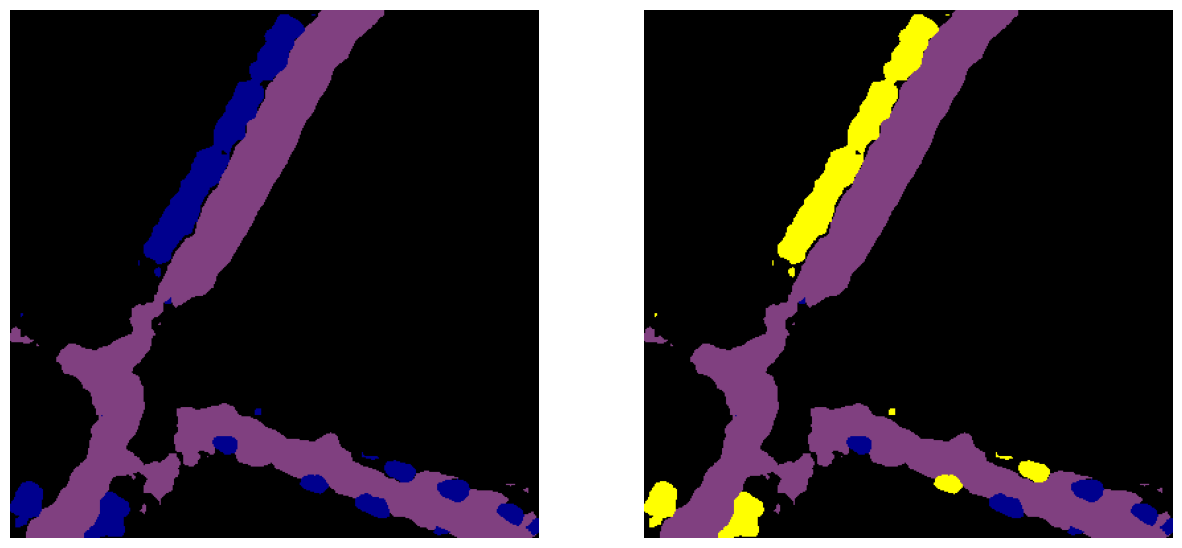

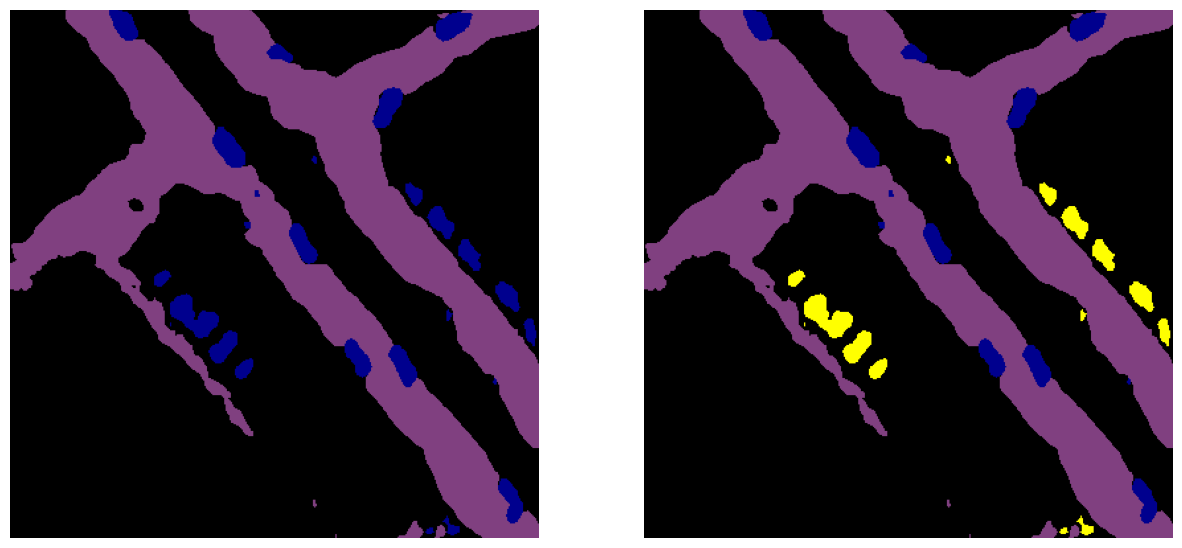

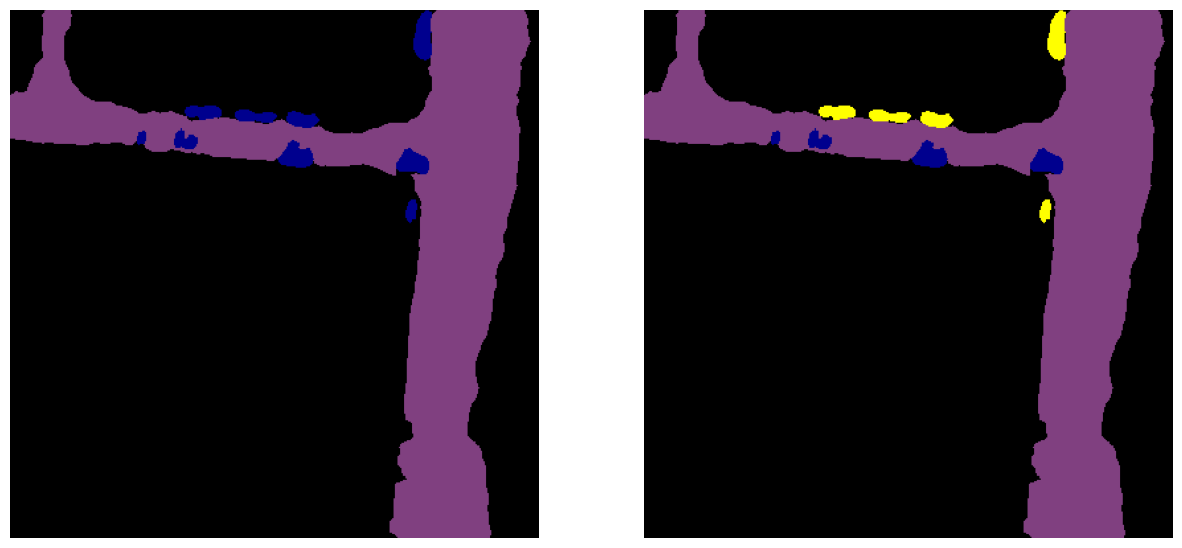

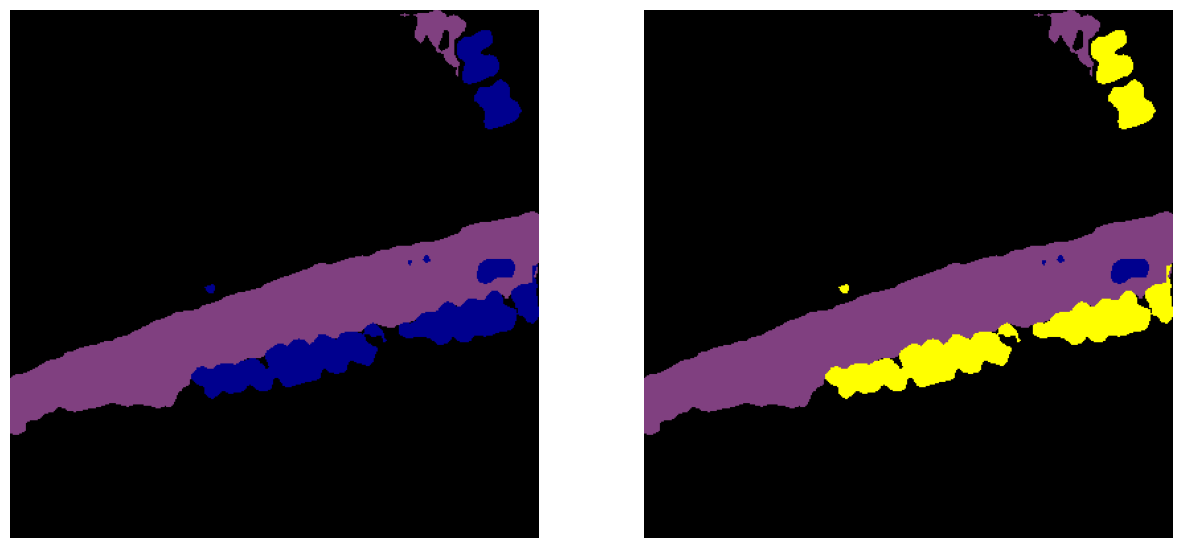

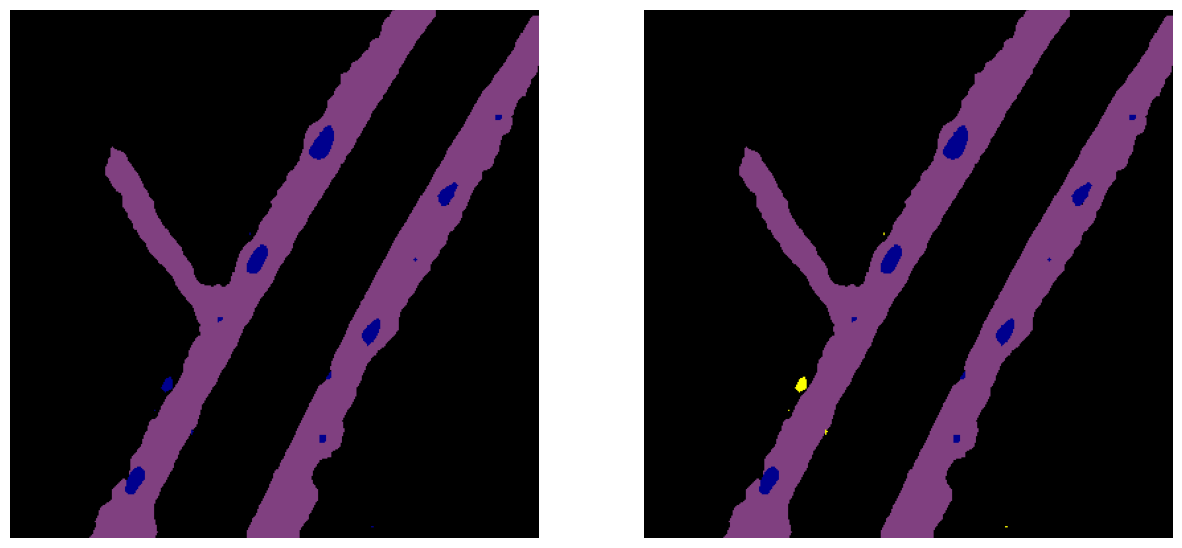

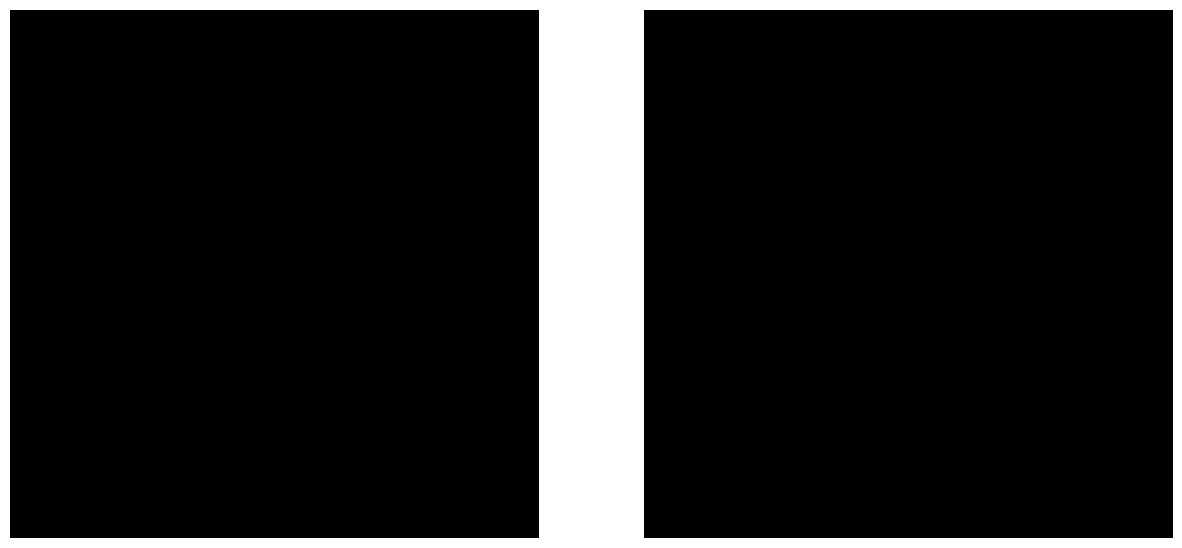

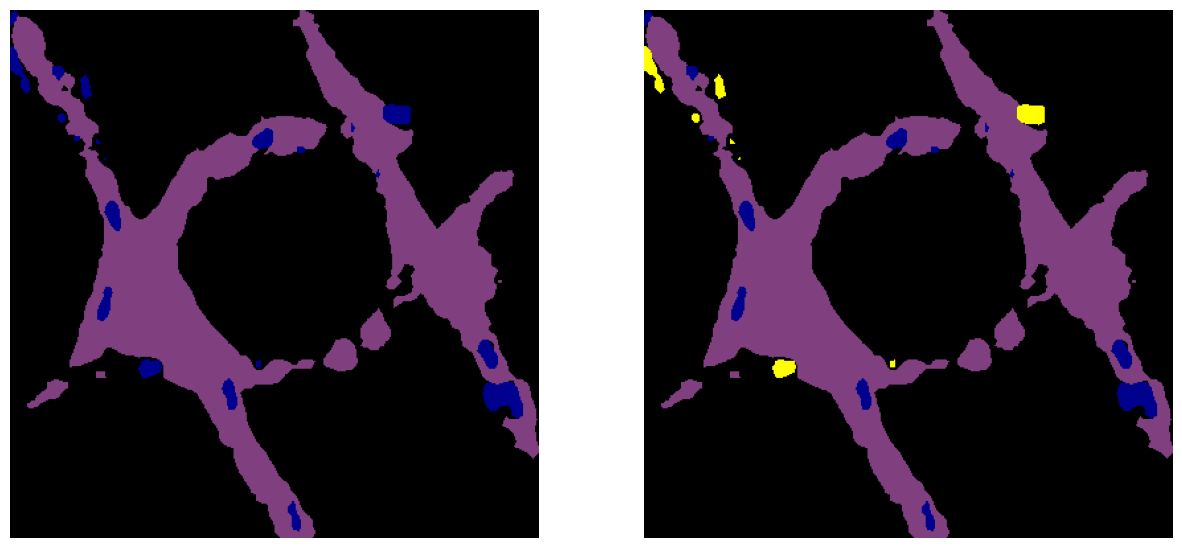

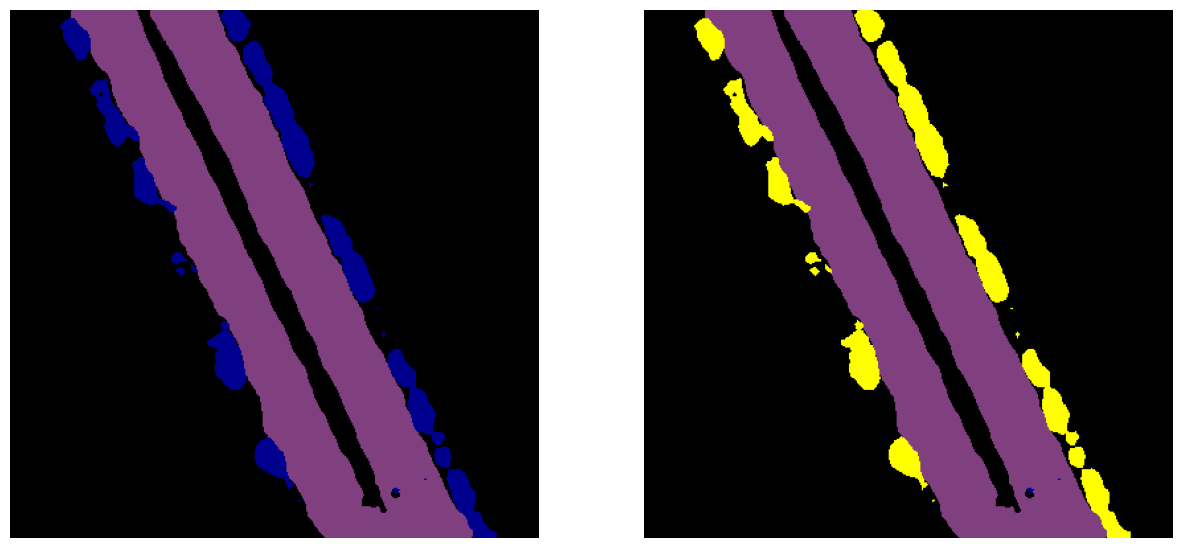

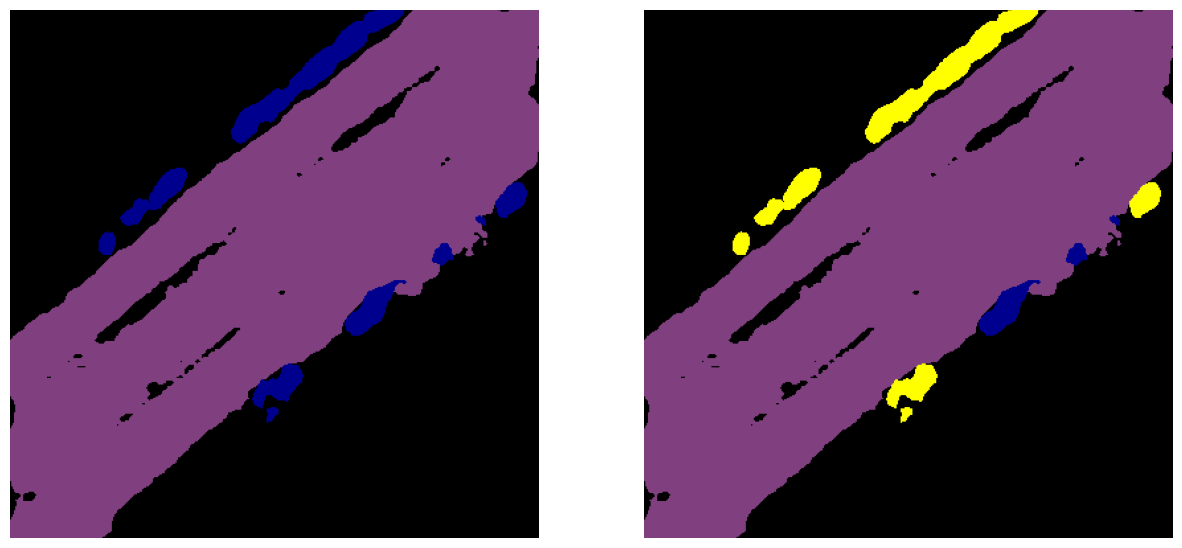

In [68]:
folder_path = '/content/drive/My Drive/FotosGranada/predicted_images'

image_files = sorted(os.listdir(folder_path))

# Adjust the size of the images
plt.rcParams['figure.figsize'] = (15, 7)

# Show the images
for i in range(0, len(image_files), 2):
    original_image = cv2.imread(os.path.join(folder_path, image_files[i]))
    aparcado_image = cv2.imread(os.path.join(folder_path, image_files[i + 1]))

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(aparcado_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

